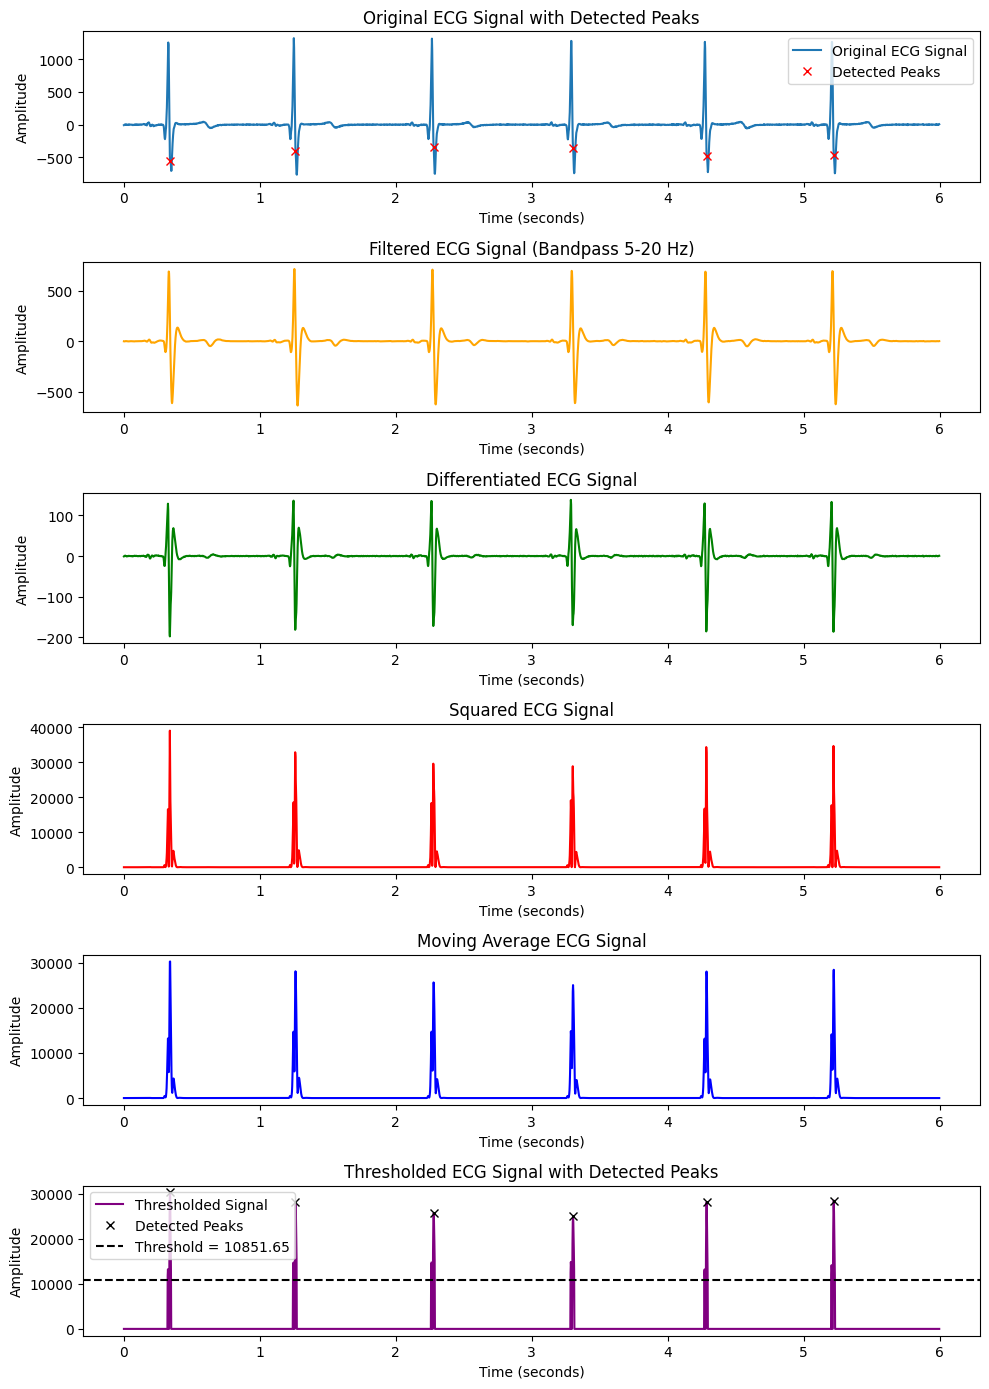

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import pandas as pd
from scipy import signal
from scipy.signal import find_peaks
from scipy import signal

sampling_rate = 500 # Update this based on your actual sampling rate
Exclude_Lead = 30  # Exclude the first lead (index 0) from the ECG data

#Important !!!!!!
#Only use the .Exg

# Lowpass and Highpass filter settings
Lowpass_setting = 5  # in Hz
Highpass_setting = 20  # in Hz
window_size = 4  # Window size for moving average
quantile_threshold = 0.95  # Ignore the top 0.5% of the values

# Function to define the bandpass filter
def define_bandpass_filter(lowcut, highcut, fs, order=1):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

# Function to apply a differentiation filter
def apply_differentiation_filter(signal):
    return np.diff(signal, n=1)

# Function to apply a squaring filter
def apply_squaring_filter(signal):
    return np.square(signal)

# Function to apply a moving average filter
def apply_moving_average_filter(signal, window_size):
    return np.convolve(signal, np.ones(window_size) / window_size, mode='same')

# Function to determine the threshold based on a quantile
def determine_threshold(signal, quantile):
    threshold_value = np.quantile(signal, quantile)
    top_values = signal[signal >= threshold_value]
    return np.mean(top_values)

# Function to detect peaks, ensuring no overlapping indices
def detect_peaks(signal, threshold, min_distance):
    peaks, _ = find_peaks(signal, height=threshold, distance=min_distance)
    detected_peaks = []
    
    for peak in peaks:
        if all(abs(peak - p) >= min_distance for p in detected_peaks):  # Check distance from previously detected peaks
            detected_peaks.append(peak)
    
    return np.array(detected_peaks)

# Load the ECG data from CSV
# Assuming the CSV has a header and the ECG signal is in a column named 'ECG'
csv_file_path = r'C:\Users\baumi\iCloudDrive\Clemson\Computational Modeling\Project 1\CODE\EKG Data\Working Example\LUIS_ECG.csv'  # Update the path to your CSV file
ecg_data = pd.read_csv(csv_file_path)  # Load CSV file

# Assuming the ECG data is in a column named 'ECG' and you have the sampling rate
ecg_data = ecg_data.iloc[Exclude_Lead:]  # Exclude the first lead if needed
ecg_matrix = ecg_data['RawSignal'].astype(float).values  # Extract the ECG signal and convaert into float
time = ecg_data['Time'].astype(float).values  # Extract the time values

# Add the missing import statement for the 'signal' module
# Apply the bandpass filter
b, a = define_bandpass_filter(Lowpass_setting, Highpass_setting, sampling_rate)
filtered_signal = signal.lfilter(b, a, ecg_matrix)  # Filter the first channel

# Apply the differentiation filter
Differentiation_signal = apply_differentiation_filter(filtered_signal)

# Apply the squaring filter
Squared_signal = apply_squaring_filter(Differentiation_signal)

# Apply the moving average filter
Moving_average_signal = apply_moving_average_filter(Squared_signal, window_size)

# Determine the threshold using a quantile-based approach
Threshold = determine_threshold(Moving_average_signal, quantile_threshold)

# Apply the threshold: Set values below the threshold to zero
Thresholded_signal = np.where(Moving_average_signal >= Threshold, Moving_average_signal, 0)

# Adjust the min distance parameter 
distance_between_peaks = 50  # Set based on expected QRS complex width

# Index-based Peak detection
# Fix the incorrect variable name in the function call
# Index-based Peak detection
detected_peaks = detect_peaks(Thresholded_signal, threshold=Threshold, min_distance=distance_between_peaks)

# Only display the first 5000 values for plotting
Thresholded_signal_5000 = Thresholded_signal[:3000]
detected_peaks_5000 = detected_peaks[detected_peaks < 3000]  

# Time vector for the first 3000 samples
time_vector = np.arange(3000) / sampling_rate

# Plot the results with time on the x-axis
plt.figure(figsize=(10, 14))

# Original signal with detected peaks
plt.subplot(6, 1, 1)
plt.plot(time_vector, ecg_matrix[:3000], label='Original ECG Signal')
plt.plot(time_vector[detected_peaks_5000], ecg_matrix[detected_peaks_5000], "x", color='red', label='Detected Peaks')
plt.title('Original ECG Signal with Detected Peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()

# Filtered signal
plt.subplot(6, 1, 2)
plt.plot(time_vector, filtered_signal[:3000], color='orange')
plt.title(f'Filtered ECG Signal (Bandpass {Lowpass_setting}-{Highpass_setting} Hz)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

# Differentiated signal
plt.subplot(6, 1, 3)
plt.plot(time_vector, Differentiation_signal[:3000], color='green')
plt.title('Differentiated ECG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

# Squared signal
plt.subplot(6, 1, 4)
plt.plot(time_vector, Squared_signal[:3000], color='red')
plt.title('Squared ECG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

# Moving average signal
plt.subplot(6, 1, 5)
plt.plot(time_vector, Moving_average_signal[:3000], color='blue')
plt.title('Moving Average ECG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

# Thresholded signal with detected peaks
plt.subplot(6, 1, 6)
plt.plot(time_vector, Thresholded_signal_5000, color='purple', label='Thresholded Signal')
plt.plot(time_vector[detected_peaks_5000], Thresholded_signal_5000[detected_peaks_5000], "x", color='black', label='Detected Peaks')
plt.axhline(y=Threshold, color='black', linestyle='--', label=f'Threshold = {Threshold:.2f}')
plt.title('Thresholded ECG Signal with Detected Peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
# after detecting the peaks, we can calculate the heart rate and the RR interval

# How many beats were detected?

print(f'Number of detected peaks: {len(detected_peaks)}')

# time of recording
time = len(ecg_matrix) / (sampling_rate)
print(f'Time of recording (in seconds): {time}')

# Calculate the RR interval

RR_interval = np.diff(detected_peaks) / sampling_rate  # in seconds
#print(f'RR intervals (in seconds): {RR_interval}')

# Calculate the heart rate

Heart_rate = 60 / RR_interval  # in beats per minute
#print(f'Heart rate (in bpm): {Heart_rate}')

# Calculate the average heart rate

Average_heart_rate = np.mean(Heart_rate)
print(f'Average heart rate (in bpm): {round(Average_heart_rate,2)}')

# standard delta t between the peaks
delta_t = np.mean(RR_interval)
print(f'Average RR interval (in seconds): {round(delta_t,5)}')


# Calculate the standard deviation of the RR interval

RR_interval_std = np.std(RR_interval)
print(f'Standard deviation of RR intervals (in seconds): {round(RR_interval_std,5)}')


Number of detected peaks: 162
Time of recording (in seconds): 159.342
Average heart rate (in bpm): 61.1
Average RR interval (in seconds): 0.98637
Standard deviation of RR intervals (in seconds): 0.06354


Standard deviation of RR intervals (in seconds): 0.06354
0.86 min
1.11 max
Number of abnormal RR intervals detected: 7


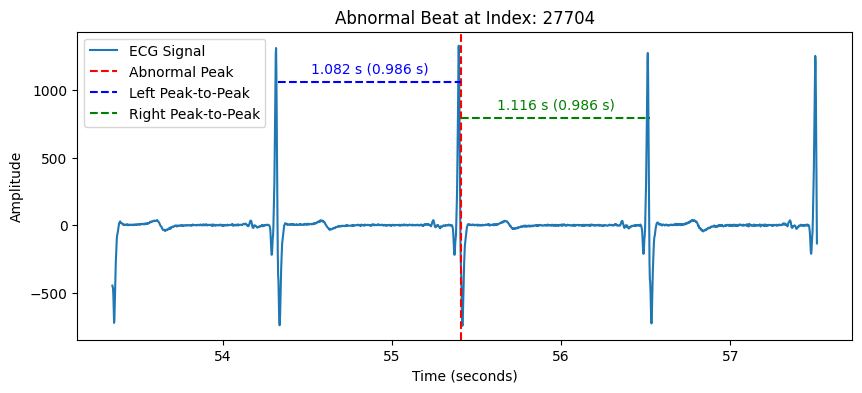

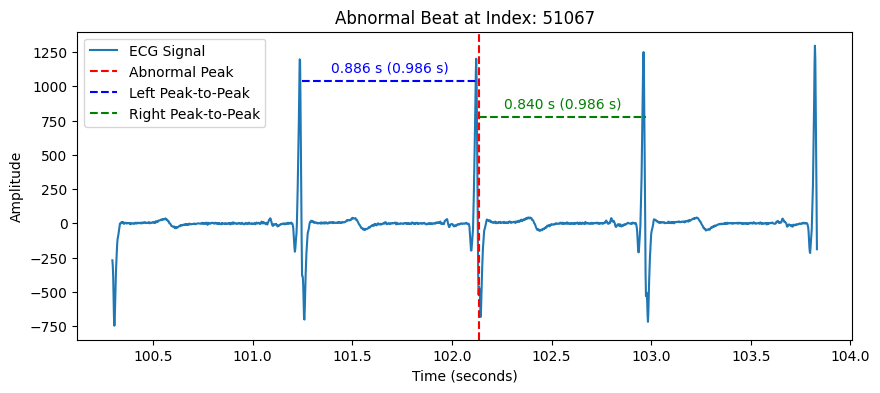

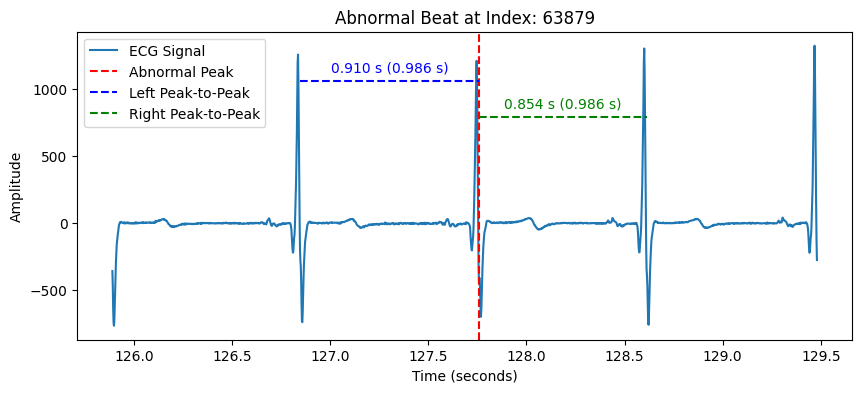

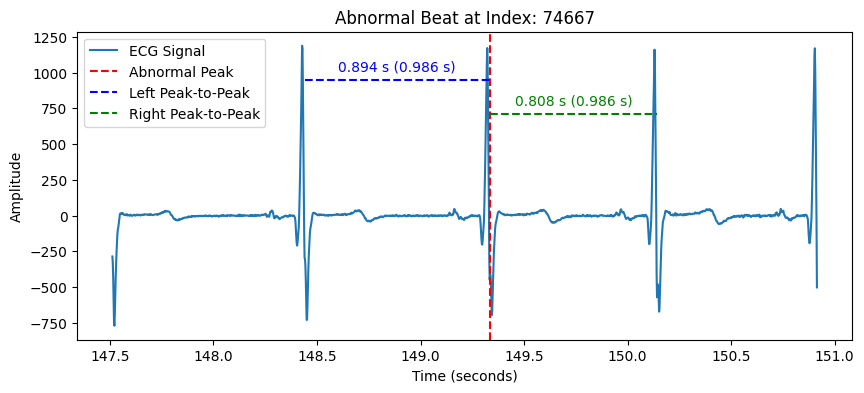

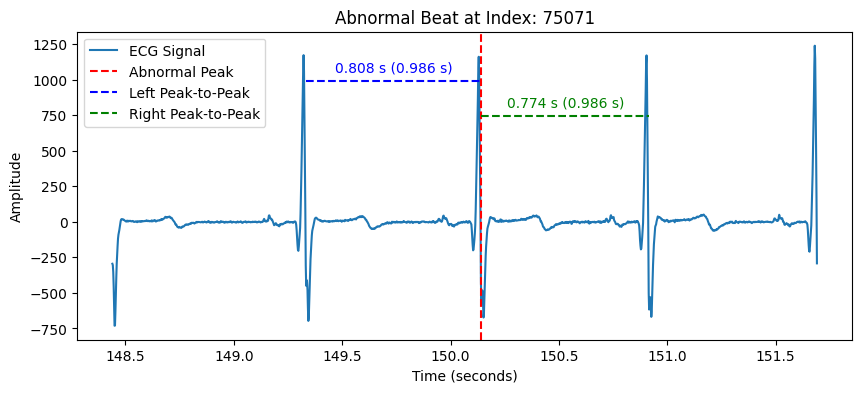

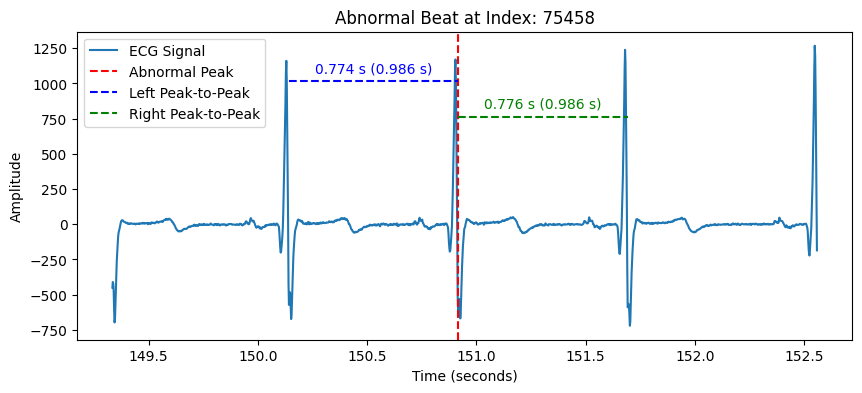

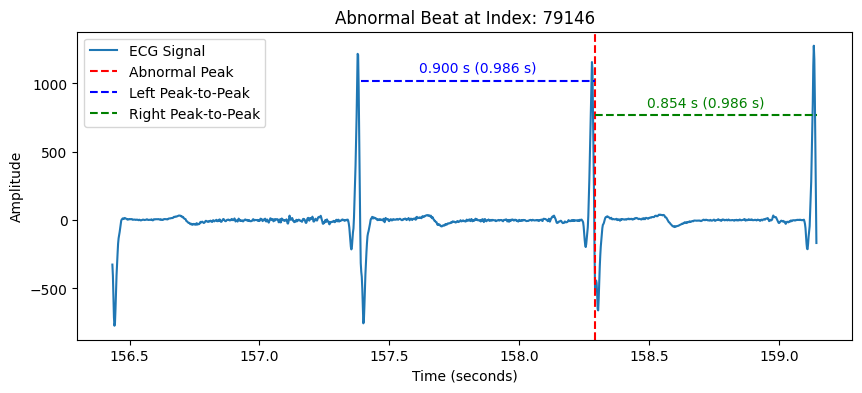

In [5]:
# Standarddeviation and Thresholds
standard_deviation = np.std(RR_interval)
print(f'Standard deviation of RR intervals (in seconds): {round(standard_deviation, 5)}')

t_max = delta_t + (2 * standard_deviation)
t_min = delta_t - (2 * standard_deviation)
print(round(t_min, 2), 'min')
print(round(t_max, 2), 'max')

# Erkennung der abnormalen RR-Intervalle
abnormal_detected_peaks = []

for i in range(len(RR_interval)):
    if t_min <= RR_interval[i] <= t_max:
        continue
    else:
        abnormal_detected_peaks.append(i)

print(f'Number of abnormal RR intervals detected: {len(abnormal_detected_peaks)}')

# Calculate the average peak-to-peak interval for all peaks (standard RR interval)
peak_intervals = np.diff(detected_peaks) / sampling_rate
average_rr_interval = np.mean(peak_intervals)

for idx in abnormal_detected_peaks:
    # Determine the indices for the plot: 2 beats before and 2 after
    start_idx = detected_peaks[max(0, idx - 2)]
    end_idx = detected_peaks[min(len(detected_peaks) - 1, idx + 2)]

    # Calculate the time values based on the sampling rate
    x_values = np.arange(start_idx, end_idx)
    time_values = x_values / sampling_rate  # Convert to seconds

    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(time_values, ecg_matrix[start_idx:end_idx], label='ECG Signal')  # Use time_values for the x-axis
    
    # Mark the abnormal peak
    current_peak_time = detected_peaks[idx] / sampling_rate
    plt.axvline(x=current_peak_time, color='red', linestyle='--', label='Abnormal Peak')

    # Peak-to-peak intervals to the left and right
    if idx > 0:  # Previous peak
        previous_peak_time = detected_peaks[idx - 1] / sampling_rate
        peak_to_peak_time_left = current_peak_time - previous_peak_time

        # Draw horizontal line and annotate
        plt.hlines(y=ecg_matrix[start_idx:end_idx].max() * 0.8, xmin=previous_peak_time, xmax=current_peak_time, color='blue', linestyle='--')
        plt.text((previous_peak_time + current_peak_time) / 2, ecg_matrix[start_idx:end_idx].max() * 0.85, 
                 f'{peak_to_peak_time_left:.3f} s ({average_rr_interval:.3f} s)', ha='center', color='blue')

    if idx < len(detected_peaks) - 1:  # Next peak
        next_peak_time = detected_peaks[idx + 1] / sampling_rate
        peak_to_peak_time_right = next_peak_time - current_peak_time

        # Draw horizontal line and annotate
        plt.hlines(y=ecg_matrix[start_idx:end_idx].max() * 0.6, xmin=current_peak_time, xmax=next_peak_time, color='green', linestyle='--')
        plt.text((current_peak_time + next_peak_time) / 2, ecg_matrix[start_idx:end_idx].max() * 0.65, 
                 f'{peak_to_peak_time_right:.3f} s ({average_rr_interval:.3f} s)', ha='center', color='green')

    plt.title(f'Abnormal Beat at Index: {detected_peaks[idx]}')
    plt.xlabel('Time (seconds)')  # x-axis as time in seconds
    plt.ylabel('Amplitude')
    
    # Adding the standard RR interval to the legend
    plt.legend(['ECG Signal', 'Abnormal Peak', 'Left Peak-to-Peak', 'Right Peak-to-Peak', f'Standard RR Interval: {average_rr_interval:.3f} s'])
    plt.show()



In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.signal import find_peaks
import tkinter as tk
from tkinter import filedialog

# Initialize Tkinter root (it won't be displayed)
root = tk.Tk()
root.withdraw()  # Hide the root window

# Open a file dialog to select the CSV file
file_path = filedialog.askopenfilename(
    title="Select the ECG CSV file",
    filetypes=[("CSV files", "*.csv"), ("All files", "*.*")]
)

# Load the ECG data from the selected CSV file
if file_path:  # Check if a file was selected
    ecg_data = pd.read_csv(file_path)  # Load CSV file
    print(f'Loaded file: {file_path}')
else:
    print("No file selected")

# Continue with the rest of your code if a file is selected
if not ecg_data.empty:
    # Assuming the ECG data is in a column named 'ECG' and you have the sampling rate
    ecg_data = ecg_data.iloc[Exclude_Lead:]  # Exclude the first lead if needed
    ecg_matrix = ecg_data['RawSignal'].astype(float).values  # Extract the ECG signal and convert into float
    time = ecg_data['Time'].astype(float).values  # Extract the time values

    # Add the missing import statement for the 'signal' module
    # Apply the bandpass filter
    b, a = define_bandpass_filter(Lowpass_setting, Highpass_setting, sampling_rate)
    filtered_signal = signal.lfilter(b, a, ecg_matrix)  # Filter the first channel

    # Apply the differentiation filter
    Differentiation_signal = apply_differentiation_filter(filtered_signal)

    # Apply the squaring filter
    Squared_signal = apply_squaring_filter(Differentiation_signal)

    # Apply the moving average filter
    Moving_average_signal = apply_moving_average_filter(Squared_signal, window_size)

    # Determine the threshold using a quantile-based approach
    Threshold = determine_threshold(Moving_average_signal, quantile_threshold)

    # Apply the threshold: Set values below the threshold to zero
    Thresholded_signal = np.where(Moving_average_signal >= Threshold, Moving_average_signal, 0)

    # Adjust the min distance parameter 
    distance_between_peaks = 50  # Set based on expected QRS complex width

    # Index-based Peak detection
    detected_peaks = detect_peaks(Thresholded_signal, threshold=Threshold, min_distance=distance_between_peaks)
    # Only display the first 5000 values for plotting
    Thresholded_signal_5000 = Thresholded_signal[:3000]
    detected_peaks_5000 = detected_peaks[detected_peaks < 3000]  

    # Time vector for the first 3000 samples
    time_vector = np.arange(3000) / sampling_rate

    # Plot the results with time on the x-axis
    plt.figure(figsize=(10, 14))

    # Original signal with detected peaks
    plt.subplot(6, 1, 1)
    plt.plot(time_vector, ecg_matrix[:3000], label='Original ECG Signal')
    plt.plot(time_vector[detected_peaks_5000], ecg_matrix[detected_peaks_5000], "x", color='red', label='Detected Peaks')
    plt.title('Original ECG Signal with Detected Peaks')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend()

    # Filtered signal
    plt.subplot(6, 1, 2)
    plt.plot(time_vector, filtered_signal[:3000], color='orange')
    plt.title(f'Filtered ECG Signal (Bandpass {Lowpass_setting}-{Highpass_setting} Hz)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')

    # Differentiated signal
    plt.subplot(6, 1, 3)
    plt.plot(time_vector, Differentiation_signal[:3000], color='green')
    plt.title('Differentiated ECG Signal')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')

    # Squared signal
    plt.subplot(6, 1, 4)
    plt.plot(time_vector, Squared_signal[:3000], color='red')
    plt.title('Squared ECG Signal')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')

    # Moving average signal
    plt.subplot(6, 1, 5)
    plt.plot(time_vector, Moving_average_signal[:3000], color='blue')
    plt.title('Moving Average ECG Signal')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')

    # Thresholded signal with detected peaks
    plt.subplot(6, 1, 6)
    plt.plot(time_vector, Thresholded_signal_5000, color='purple', label='Thresholded Signal')
    plt.plot(time_vector[detected_peaks_5000], Thresholded_signal_5000[detected_peaks_5000], "x", color='black', label='Detected Peaks')
    plt.axhline(y=Threshold, color='black', linestyle='--', label=f'Threshold = {Threshold:.2f}')
    plt.title('Thresholded ECG Signal with Detected Peaks')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No data to process.")